## Segments and events selection

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import transport_signal_processing as tsp
from data_manager import DataManager
from selection import segments_selection, events_selection
from plot_utils import plot_selected_segments, plot_selected_events

### Selecting data to process

In [2]:
# parameter
path = "K238A_20C_*mV_*Oxytocin"
sel_key = "condition"
condition_keys = ['voltage']

# setup database connector
sigman = DataManager('database', safe=False)

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l).fillna(0.0).query("N_cores > 1").sort_values("N_cores", ascending=False)

# add full condition key
df['condition'] = df.apply(lambda x: '-'.join([str(x[ck]) for ck in condition_keys]), axis=1)

# debug print
display(df)

# debug print
keys = np.unique(df[sel_key].values)
print(keys.shape[0])
pprint(list(keys))

UndefinedVariableError: name 'N_cores' is not defined

### 1. Segments selection

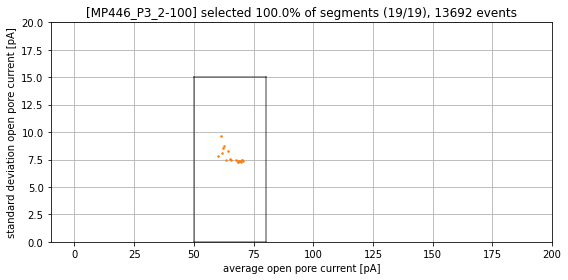

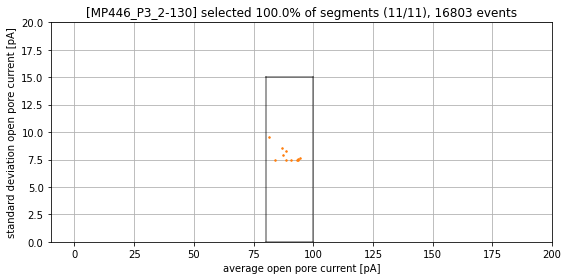

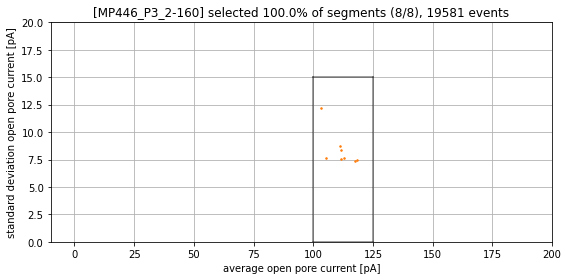

In [3]:
# parameters
params = {
    'default': {'mI_open_lims':[0, 100], 'sI_open_lims':[0, 20]},
    'MP446_P3_2-100': {'mI_open_lims':[50, 80], 'sI_open_lims':[0, 15]},
    'MP446_P3_2-130': {'mI_open_lims':[80, 100], 'sI_open_lims':[0, 15]},
    'MP446_P3_2-160': {'mI_open_lims':[100, 125], 'sI_open_lims':[0, 15]},  
}
 

# for all subsets
for key in keys:
    # get parameters
    if key in params:
        mI_open_lims = params[key]['mI_open_lims']
        sI_open_lims = params[key]['sI_open_lims']
    else:
        mI_open_lims = params['default']['mI_open_lims']
        sI_open_lims = params['default']['sI_open_lims']
    
    # get segments information
    dfs = df[df[sel_key] == key]
    sinfo_l = dfs.to_dict("records")

    # select segments
    m = segments_selection(sigman, sinfo_l, mI_open_lims, sI_open_lims)

    # extract selected data and statistics
    n_sel = np.sum(m)
    N_sigs = m.shape[0]
    p_sel = 100.0 * float(n_sel) / float(N_sigs)
    N_events = int(np.sum(dfs[m]['N_cores'].values))

    # plot
    plt.figure(figsize=(8,4))
    plot_selected_segments(dfs['mI_open'].values, dfs['sI_open'].values, mI_open_lims, sI_open_lims, m)
    plt.xlabel('average open pore current [pA]')
    plt.ylabel('standard deviation open pore current [pA]')
    plt.title('[{}] selected {:.1f}% of segments ({}/{}), {} events'.format(key, p_sel, n_sel, N_sigs, N_events))
    plt.xlim(-10.0, 200.0)
    plt.ylim(0.0, 20.0)
    plt.grid()
    plt.tight_layout()
    plt.show()

### 2. Divergence filtering

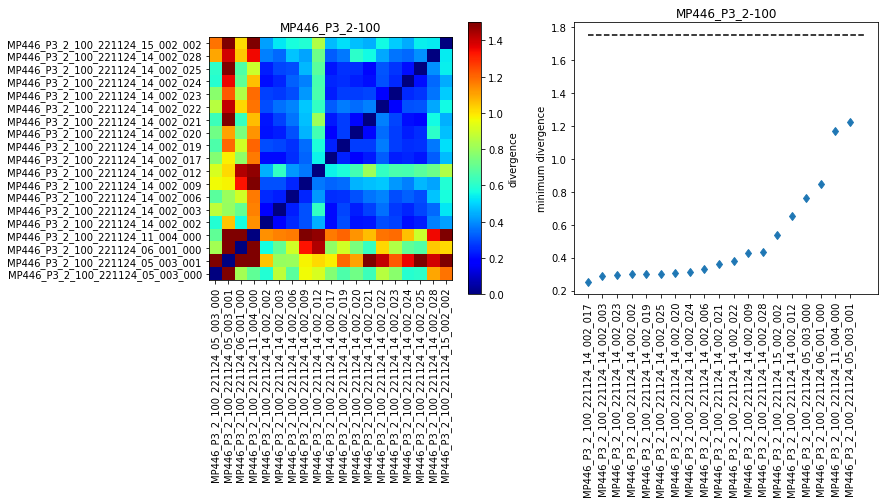

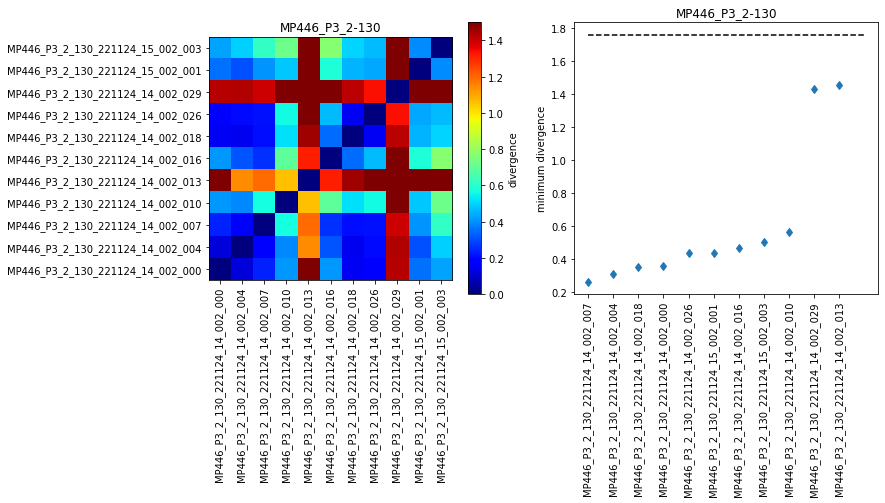

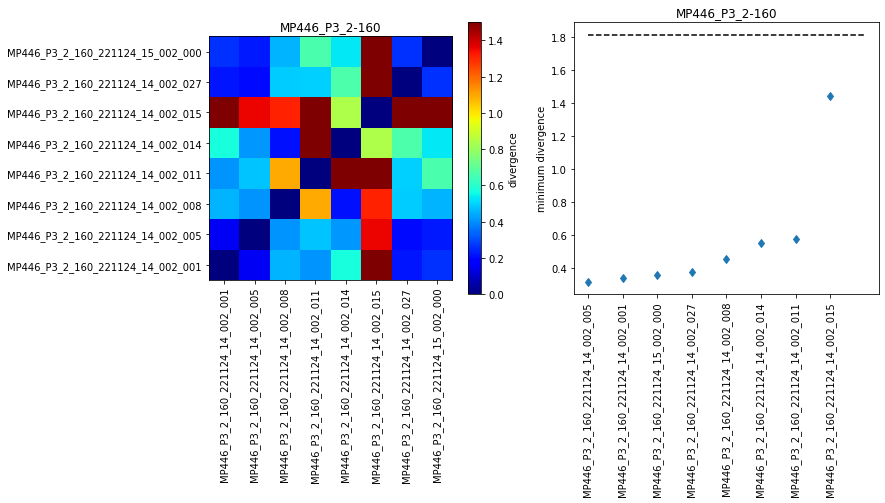

In [4]:
# parameters
params = {
    'default': {'div_thr': 1.5},
}
ukeys = ['analyte', 'voltage', 'date', 'recording', 'channel', 'count']

# for all subsets
for key in keys:
    # get parameters
    if key in params:
        div_thr = params[key]['div_thr']
    else:
        div_thr = params['default']['div_thr']
    
    # reload segments informations
    sinfo_l = sigman.load_info(path, 's*')
    df = pd.DataFrame(sinfo_l).query("selected > 0")
    df['condition'] = df.apply(lambda x: '-'.join([str(x[ck]) for ck in condition_keys]), axis=1)
    
    # get segments information
    dfs = df[df[sel_key] == key].copy()
    
    # assign unique instance id
    dfs['uid'] = dfs[ukeys].astype(str).apply(lambda x: '_'.join(x), axis=1).values
    if dfs.shape[0] == 0:
        print("No segment selected for {}".format(key))
        continue

    # load stats grouped by selected key
    stats_dict = tsp.utils.load_stats_for_key(sigman, dfs.to_dict('records'), 'uid', selected_only=False)

    # dimension reduction
    stats_l = list(stats_dict.values())
    stats_l = [stats[:,:2] for stats in stats_l]

    # compute combined statistical divergence between measurements
    D = tsp.stats.divergence_matrix(stats_l)
    #D[np.arange(D.shape[0]), np.arange(D.shape[0])] += np.max(D)
    
    # average divergence
    d = np.median(D, axis=0)
    ids_srtd = np.argsort(d)
    
    # figure
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(D, cmap='jet', origin='lower', vmin=0.0, vmax=div_thr)
    plt.colorbar(label='divergence')
    plt.yticks(np.arange(D.shape[0]), list(stats_dict))
    plt.xticks(np.arange(D.shape[0]), list(stats_dict), rotation=90)
    plt.title(key)
    
    plt.subplot(1,2,2)
    plt.plot(d[ids_srtd], 'd')
    plt.plot([0, ids_srtd.shape[0]], [div_thr+np.min(d)]*2, 'k--')
    plt.xticks(np.arange(ids_srtd.shape[0]), np.array(list(stats_dict))[ids_srtd], rotation=90)
    plt.ylabel("minimum divergence")
    plt.title(key)
    plt.show()

    # update database
    uid_map = {}
    for k,uid in enumerate(dfs['uid']):
        if uid in uid_map:
            uid_map[uid].append(k)
        else:
            uid_map[uid] = [k]

    for i in range(len(d)):
        for k in uid_map[list(stats_dict)[i]]:
            sinfo = dfs.iloc[k].to_dict()
            bsel = (d[i] < (div_thr + np.min(d)))
            sigman.insert_info(sinfo, 's{}'.format(sinfo['sid']), selected=int(bsel))

### 3. Events selection

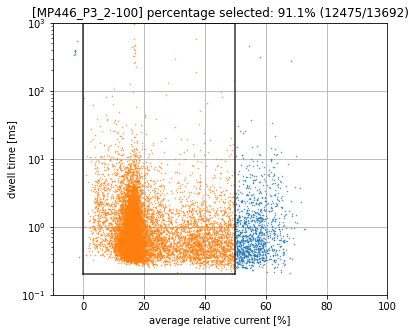

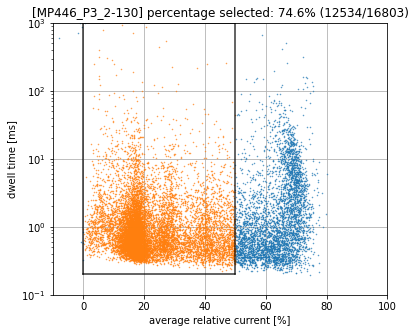

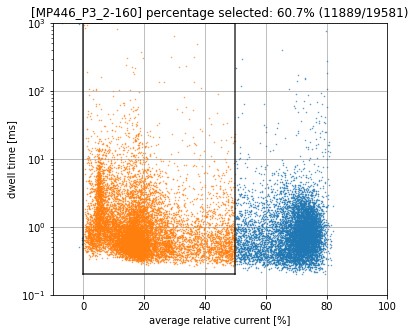

In [5]:
# parameters
# I_lims: limits of the current given in percent of blockade of the open pore, 100% = open pore, 0% = blocked pore
# t_lims: limits of the dwell time [ms]
params = {
    'default': {'I_lims':[0, 50], 't_lims':[0.2, 1000]},
}

# for all subsets
for key in keys:
    # get parameters
    if key in params:
        I_lims = params[key]['I_lims']
        t_lims = params[key]['t_lims']
    else:
        I_lims = params['default']['I_lims']
        t_lims = params['default']['t_lims']
    
    # reload segments informations
    sinfo_l = sigman.load_info(path, 's*')
    dfs = pd.DataFrame(sinfo_l).query("selected > 0")
    dfs['condition'] = dfs.apply(lambda x: '-'.join([str(x[ck]) for ck in condition_keys]), axis=1)
    
    # get segments information
    sinfo_l = dfs[dfs[sel_key] == key].to_dict("records")
    if len(sinfo_l) == 0:
        print("No segment selected for {}".format(key))
        continue

    # select events
    stats, mf = events_selection(sigman, sinfo_l, I_lims, t_lims)

    # compute ratio of filtering
    n_sel = np.sum(mf)
    n_tot = mf.shape[0]
    r_sel = float(n_sel) / float(n_tot)

    # plot
    plt.figure(figsize=(6,5))
    #plt.subplot(121)
    plot_selected_events(stats, I_lims, t_lims, mf, alpha=0.8)
    plt.xlim(-10, 100)
    plt.ylim(0.1, 1000)
    plt.xlabel('average relative current [%]')
    plt.ylabel('dwell time [ms]')
    plt.title("[{}] percentage selected: {:.1f}% ({}/{})".format(key, 100.0*r_sel, n_sel, n_tot))
    plt.grid()
    #plt.tight_layout()
    plt.savefig("graphs/events_sel_{}.png".format(key), dpi=200)
    plt.show()

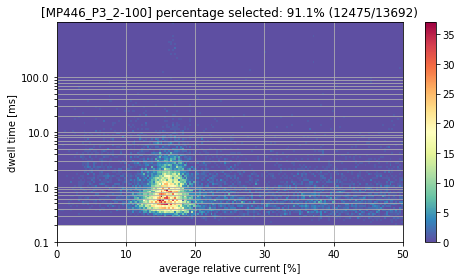

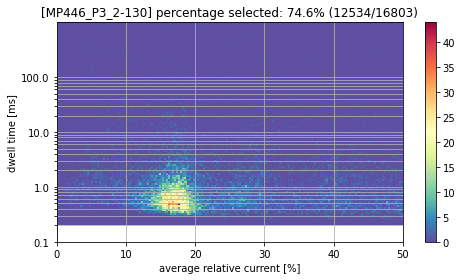

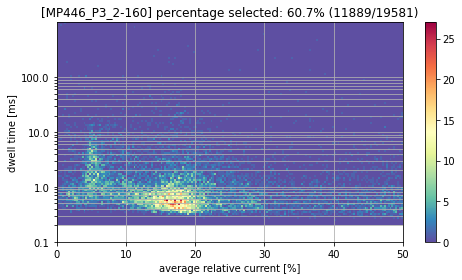

In [6]:
# for all subsets
for key in keys:
    # get parameters
    if key in params:
        I_lims = params[key]['I_lims']
        t_lims = params[key]['t_lims']
    else:
        I_lims = params['default']['I_lims']
        t_lims = params['default']['t_lims']
    
    # reload segments informations
    sinfo_l = sigman.load_info(path, 's*')
    dfs = pd.DataFrame(sinfo_l).query("selected > 0")
    dfs['condition'] = dfs.apply(lambda x: '-'.join([str(x[ck]) for ck in condition_keys]), axis=1)
    
    # get segments information
    sinfo_l = dfs[dfs[sel_key] == key].to_dict("records")
    if len(sinfo_l) == 0:
        print("No segment selected for {}".format(key))
        continue

    # select events
    stats, mf = events_selection(sigman, sinfo_l, I_lims, t_lims)
    
    # compute ratio of filtering
    n_sel = np.sum(mf)
    n_tot = mf.shape[0]
    r_sel = float(n_sel) / float(n_tot)
    
    # extract data
    x = stats[:,1].copy()
    y = np.log10(1e3*stats[:,0].copy())
    
    # make log ticks
    yticks = np.concatenate([np.linspace(0.1, 1.0, 10), np.linspace(2.0, 10.0, 9), np.linspace(20.0, 100.0, 9)])
    yticks_labels = []
    for t in yticks:
        if t in [0.1, 1.0, 10.0, 100.0]:
            yticks_labels.append(str(t))
        else:
            yticks_labels.append('')
            
    # plot
    plt.figure(figsize=(7,4))
    plt.hist2d(x,y, bins=(180,100), range=((I_lims[0],I_lims[1]),(np.log10(t_lims[0]),np.log10(t_lims[1]))), cmap='Spectral_r')
    plt.colorbar()
    plt.yticks(np.log10(yticks), yticks_labels)
    plt.xlabel('average relative current [%]')
    plt.ylabel('dwell time [ms]')
    plt.title("[{}] percentage selected: {:.1f}% ({}/{})".format(key, 100.0*r_sel, n_sel, n_tot))
    plt.grid()
    plt.tight_layout()
    plt.savefig("graphs/events_distribution_{}.png".format(key), dpi=200)
    plt.show()